In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from helper import *
from scipy.stats import skew
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("./prepared_data.csv")
test_df =  pd.read_csv("./prepared_data_test.csv")

In [3]:
X_train_preprocessed, X_test_preprocessed, y_train, y_test, preprocessor = preprocess_data(
    df,
    "Item_Outlet_Sales",
)

models = [
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor()),
    ('XGBoost Regressor', XGBRegressor()),
]

results = {}

for model_name, model_instance in models:
    model = model_instance
    model.fit(X_train_preprocessed, y_train)
    
    # Predictions on training set
    y_train_pred = model.predict(X_train_preprocessed)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Predictions on testing set
    y_test_pred = model.predict(X_test_preprocessed)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results[model_name] = {
        'model': model,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }



plot_results(results, X_test_preprocessed, y_test)


Model: Random Forest
Training MSE: 141938.18058455264
Training RMSE: 376.74683885143963
Training R^2: 0.936473491249843
Testing MSE: 1089845.413061944
Testing RMSE: 1043.9566145496392
Testing R^2: 0.532439254601407
Model: Gradient Boosting Regressor
Training MSE: 854967.6804011634
Training RMSE: 924.6446238426757
Training R^2: 0.6173467096279176
Testing MSE: 994427.3663268444
Testing RMSE: 997.2097905289761
Testing R^2: 0.5733750905660671
Model: XGBoost Regressor
Training MSE: 341651.6298311878
Training RMSE: 584.5097345906121
Training R^2: 0.8470888159719133
Testing MSE: 1139302.7376128244
Testing RMSE: 1067.3812522303474
Testing R^2: 0.511221288039102


In [4]:
X_train_preprocessed, X_test_preprocessed, y_train, y_test, preprocessor = preprocess_data(df, "Item_Outlet_Sales")

# Define models
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Map models to their respective hyperparameter grids
param_grids = {
    'Random Forest': param_grid_rf,
    'Gradient Boosting Regressor': param_grid_gb,
    'XGBoost Regressor': param_grid_xgb
}

models = {
    # 'Random Forest': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    # 'XGBoost Regressor': XGBRegressor()
}

In [9]:
results = dict() 
grid_search = None
for model_name, model_instance in models.items():
    model = model_instance
    
    # Choose the number of folds (e.g., 5-fold cross-validation)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_preprocessed, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_train_pred = best_model.predict(X_train_preprocessed)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    y_test_pred = best_model.predict(X_test_preprocessed)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results[model_name] = {
        'model': best_model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }





In [16]:
grid_search.best_estimator_

GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=10,
                          n_estimators=50)

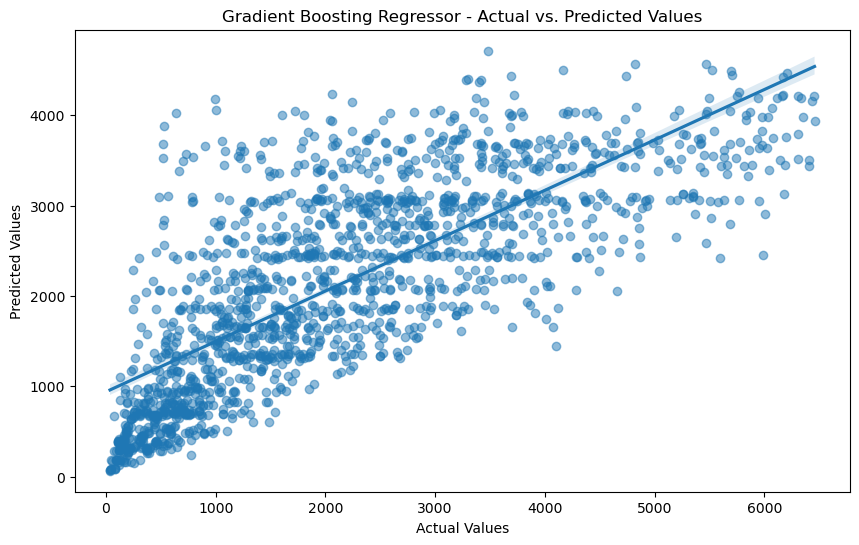

In [18]:
best_model = grid_search.best_estimator_
best_params =  grid_search.best_params_
y_pred = best_model.predict(X_test_preprocessed)

plt.figure(figsize=(10, 6))

sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5})
plt.title(f"{model_name} - Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()
    

In [19]:
import joblib
import json

joblib.dump(best_model, 'best_model.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')

best_params = grid_search.best_params_

with open('best_parameters.json', 'w') as json_file:
    json.dump(best_params, json_file)


In [20]:

loaded_model = joblib.load('best_model.joblib')
loaded_preprocessor = joblib.load('preprocessor.joblib')

with open('best_parameters.json', 'r') as json_file:
    loaded_best_params = json.load(json_file)

loaded_model_with_params = GradientBoostingRegressor(**loaded_best_params)



In [21]:

X_test_preprocessed = preprocessor.transform(test_df)

y_test_pred = loaded_model.predict(X_test_preprocessed)

predictions_df = pd.DataFrame({'Item_Outlet_Sales_Prediction': y_test_pred})
predictions_df.to_csv('predictions.csv', index=False)
